In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
test_data = pd.read_csv('/content/credit_overdue_processed_smote_test.csv').drop(['Unnamed: 0','ID'],axis=1).dropna()
dev_data = pd.read_csv('/content/credit_overdue_processed_smote_dev.csv').drop(['Unnamed: 0','ID'],axis=1).dropna()

In [3]:
# the first column is an index and the second is just the ID, the last column is the target
X_train = dev_data.iloc[:, 2:-1].values
y_train = dev_data.iloc[:, -1].values

X_test = test_data.iloc[:, 2:-1].values
y_test = test_data.iloc[:, -1].values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Baseline small model

In [5]:
import torch.nn as nn
import torch.nn.functional as F
class Neural_net(nn.Module):
  def __init__(self):
    super(Neural_net,self).__init__()
    self.fc1 = nn.Linear(44, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256,64)
    self.fc4 = nn.Linear(64,1)


  def forward(self,x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = F.leaky_relu(self.fc3(x))
    x = self.fc4(x)
    return x








In [6]:
model = Neural_net()
model.train()
criterion = nn.BCEWithLogitsLoss()
weight_value = 2
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight_value]))
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

total_loss = 0
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs} Loss: {epoch_loss/len(train_loader)}')






Epoch 1/10 Loss: 0.6918548030170752
Epoch 2/10 Loss: 0.5625930033585568
Epoch 3/10 Loss: 0.5043202576859628
Epoch 4/10 Loss: 0.46787610132768365
Epoch 5/10 Loss: 0.44339656598209715
Epoch 6/10 Loss: 0.42417596716800504
Epoch 7/10 Loss: 0.40935649201659957
Epoch 8/10 Loss: 0.39813114125571103
Epoch 9/10 Loss: 0.38452546203923965
Epoch 10/10 Loss: 0.37690675802953505


In [10]:
def calculate_accuracy(y_pred, y_true):
    predictions = (y_pred >= 0.5).float()  # Applying threshold
    correct = (predictions == y_true).float()  # convert boolean to float
    accuracy = correct.sum() / len(correct)
    return accuracy


In [11]:
from sklearn.metrics import roc_auc_score

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    true_positives = 0
    predicted_positives = 0
    actual_positives = 0
    all_preds = []
    all_targets = []

    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        predictions = (outputs >= 0.5).float()  # Applying threshold

        # Collect all predictions and true labels for AUC calculation
        all_preds.extend(outputs.cpu().detach().numpy())  # Storing prediction probabilities for AUC
        all_targets.extend(batch_y.cpu().detach().numpy())  # Storing actual labels for AUC

        total += batch_y.size(0)
        correct += (predictions == batch_y).sum().item()

        # Count actual positives (ground truth)
        actual_positives += (batch_y == 1).sum().item()

        # Count predicted positives
        predicted_positives += (predictions == 1).sum().item()

        # Count true positives
        true_positives += ((predictions == 1) & (batch_y == 1)).sum().item()

    accuracy = 100 * correct / total
    precision = 100 * true_positives / predicted_positives if predicted_positives > 0 else 0
    recall = 100 * true_positives / actual_positives if actual_positives > 0 else 0
    auc_roc = roc_auc_score(all_targets, all_preds)  # Calculating the ROC AUC score

    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}%')
    print(f'Recall: {recall:.2f}%')
    print(f'ROC AUC: {auc_roc:.3f}')

Accuracy: 83.35%
Precision: 28.80%
Recall: 28.76%
ROC AUC: 0.685


# **We'll add a drop out and see if that improves the model's performance**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Neural_net(nn.Module):
    def __init__(self):
      super(Neural_net,self).__init__()
      self.fc1 = nn.Linear(44, 128)
      self.fc2 = nn.Linear(128, 256)
      self.fc3 = nn.Linear(256,64)
      self.fc4 = nn.Linear(64,1)
      self.dropout = nn.Dropout(.5)


    def forward(self,x):
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = F.leaky_relu(self.fc3(x))
      x =self.fc4(x)
      return x



In [ ]:
model = Neural_net()
model.train()
criterion = nn.BCEWithLogitsLoss()
weight_value = 2
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight_value]))
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

total_loss = 0
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs} Loss: {epoch_loss/len(train_loader)}')






Epoch 1/10 Loss: 0.698491322639075
Epoch 2/10 Loss: 0.5657918384115312
Epoch 3/10 Loss: 0.5043924619767024
Epoch 4/10 Loss: 0.4674483975057775
Epoch 5/10 Loss: 0.442572466450034
Epoch 6/10 Loss: 0.4226721328697674
Epoch 7/10 Loss: 0.4099873990746977
Epoch 8/10 Loss: 0.39937696192857514
Epoch 9/10 Loss: 0.3855852479588028
Epoch 10/10 Loss: 0.37674926893081073


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    true_positives = 0
    predicted_positives = 0
    actual_positives = 0

    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        predictions = (outputs >= 0.5).float()  # Applying threshold

        total += batch_y.size(0)
        correct += (predictions == batch_y).sum().item()

        # Count actual positives (ground truth)
        actual_positives += (batch_y == 1).sum().item()

        # Count predicted positives
        predicted_positives += (predictions == 1).sum().item()

        # Count true positives
        true_positives += ((predictions == 1) & (batch_y == 1)).sum().item()

    accuracy = 100 * correct / total
    precision = 100 * true_positives / predicted_positives if predicted_positives > 0 else 0
    recall = 100 * true_positives / actual_positives if actual_positives > 0 else 0

    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}%')
    print(f'Recall: {recall:.2f}%')


Accuracy: 82.34%
Precision: 27.36%
Recall: 30.84%


# **Very high variance in results We'll add multiple epochs and see if that improves**

In [ ]:
model = Neural_net()
model.train()
criterion = nn.BCEWithLogitsLoss()
weight_value = 2
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight_value]))
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

total_loss = 0
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs} Loss: {epoch_loss/len(train_loader)}')






Epoch 1/50 Loss: 0.6957345976653494
Epoch 2/50 Loss: 0.5638623717844178
Epoch 3/50 Loss: 0.5011738309048
Epoch 4/50 Loss: 0.46885484567037516
Epoch 5/50 Loss: 0.4416678359857495
Epoch 6/50 Loss: 0.42207273856345856
Epoch 7/50 Loss: 0.40810638206764827
Epoch 8/50 Loss: 0.3945162314149537
Epoch 9/50 Loss: 0.38717718042163035
Epoch 10/50 Loss: 0.37667790057205164
Epoch 11/50 Loss: 0.3684275019238341
Epoch 12/50 Loss: 0.36071954728369576
Epoch 13/50 Loss: 0.35290165516243854
Epoch 14/50 Loss: 0.3466947397574242
Epoch 15/50 Loss: 0.3421238334125651
Epoch 16/50 Loss: 0.33771546432082516
Epoch 17/50 Loss: 0.3335838521410919
Epoch 18/50 Loss: 0.3280887955249591
Epoch 19/50 Loss: 0.32388278232028445
Epoch 20/50 Loss: 0.32018460130676085
Epoch 21/50 Loss: 0.3154845282319605
Epoch 22/50 Loss: 0.3122315785408483
Epoch 23/50 Loss: 0.30839697150947826
Epoch 24/50 Loss: 0.30752390220645487
Epoch 25/50 Loss: 0.3034137651864729
Epoch 26/50 Loss: 0.300343712357505
Epoch 27/50 Loss: 0.2972134760547178
Ep

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    true_positives = 0
    predicted_positives = 0
    actual_positives = 0

    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        predictions = (outputs >= 0.5).float()  # Applying threshold

        total += batch_y.size(0)
        correct += (predictions == batch_y).sum().item()

        # Count actual positives (ground truth)
        actual_positives += (batch_y == 1).sum().item()

        # Count predicted positives
        predicted_positives += (predictions == 1).sum().item()

        # Count true positives
        true_positives += ((predictions == 1) & (batch_y == 1)).sum().item()

    accuracy = 100 * correct / total
    precision = 100 * true_positives / predicted_positives if predicted_positives > 0 else 0
    recall = 100 * true_positives / actual_positives if actual_positives > 0 else 0

    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}%')
    print(f'Recall: {recall:.2f}%')


Accuracy: 84.28%
Precision: 33.79%
Recall: 35.86%


## Larger model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Neural_net(nn.Module):
    def __init__(self):
        super(Neural_net, self).__init__()
        self.fc1 = nn.Linear(44, 256)
        self.fc2 = nn.Linear(256, 360)
        self.fc3 = nn.Linear(360, 480)
        self.fc4 = nn.Linear(480, 180)
        self.fc5 = nn.Linear(180, 120)
        self.fc6 = nn.Linear(120, 64)
        self.fc7 = nn.Linear(64, 1)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x


In [ ]:
model = Neural_net()
model.train()
criterion = nn.BCEWithLogitsLoss()
weight_value = 3
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight_value]))
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

total_loss = 0
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs} Loss: {epoch_loss/len(train_loader)}')






KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    true_positives = 0
    predicted_positives = 0
    actual_positives = 0

    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        predictions = (outputs >= 0.5).float()  # Applying threshold

        total += batch_y.size(0)
        correct += (predictions == batch_y).sum().item()

        # Count actual positives (ground truth)
        actual_positives += (batch_y == 1).sum().item()

        # Count predicted positives
        predicted_positives += (predictions == 1).sum().item()

        # Count true positives
        true_positives += ((predictions == 1) & (batch_y == 1)).sum().item()

    accuracy = 100 * correct / total
    precision = 100 * true_positives / predicted_positives if predicted_positives > 0 else 0
    recall = 100 * true_positives / actual_positives if actual_positives > 0 else 0

    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}%')
    print(f'Recall: {recall:.2f}%')


Accuracy: 78.13%
Precision: 25.40%
Recall: 44.92%


In [ ]:
model = Neural_net()
model.train()
criterion = nn.BCEWithLogitsLoss()
weight_value = 2
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight_value]))
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

total_loss = 0
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs} Loss: {epoch_loss/len(train_loader)}')






Epoch 1/50 Loss: 0.6973292372078476
Epoch 2/50 Loss: 0.5608940988856276
Epoch 3/50 Loss: 0.49339274091192475
Epoch 4/50 Loss: 0.45640888636439575
Epoch 5/50 Loss: 0.43336192118920813
Epoch 6/50 Loss: 0.41065546657909385
Epoch 7/50 Loss: 0.3963025000158678
Epoch 8/50 Loss: 0.38404540313465685
Epoch 9/50 Loss: 0.37142610905083967
Epoch 10/50 Loss: 0.3612458930770659
Epoch 11/50 Loss: 0.35772633859453423
Epoch 12/50 Loss: 0.34849250395758163
Epoch 13/50 Loss: 0.3411412119209149
Epoch 14/50 Loss: 0.3363059378311115
Epoch 15/50 Loss: 0.3304021356752808
Epoch 16/50 Loss: 0.32478291116693475
Epoch 17/50 Loss: 0.33054720882538685
Epoch 18/50 Loss: 0.31513552260561
Epoch 19/50 Loss: 0.30841018386918645
Epoch 20/50 Loss: 0.3055283086364751
Epoch 21/50 Loss: 0.30328678056945146
Epoch 22/50 Loss: 0.2992365341537048
Epoch 23/50 Loss: 0.29430596760131533
Epoch 24/50 Loss: 0.29413158097183767
Epoch 25/50 Loss: 0.28600058264528533
Epoch 26/50 Loss: 0.28879000573694086
Epoch 27/50 Loss: 0.2826983599387

Accuracy: 80.45%
Precision: 29.00%
Recall: 46.39%
ROC AUC: 0.72


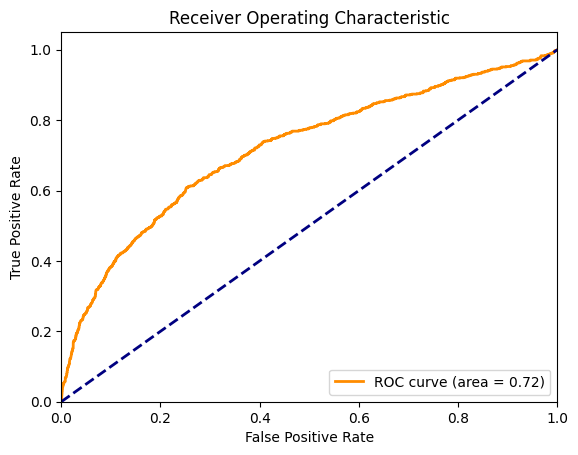

In [ ]:
import torch
from sklearn.metrics import roc_curve, auc

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    true_positives = 0
    predicted_positives = 0
    actual_positives = 0

    # Lists to store all predictions and labels
    all_labels = []
    all_predictions = []

    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        probabilities = torch.sigmoid(outputs)  # Assuming binary classification with sigmoid activation
        predictions = (probabilities >= 0.5).float()

        total += batch_y.size(0)
        correct += (predictions == batch_y).sum().item()

        actual_positives += (batch_y == 1).sum().item()
        predicted_positives += (predictions == 1).sum().item()
        true_positives += ((predictions == 1) & (batch_y == 1)).sum().item()

        # Append batch results to list
        all_labels.extend(batch_y.tolist())
        all_predictions.extend(probabilities.tolist())

    accuracy = 100 * correct / total
    precision = 100 * true_positives / predicted_positives if predicted_positives > 0 else 0
    recall = 100 * true_positives / actual_positives if actual_positives > 0 else 0

    # Calculate ROC AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)

    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}%')
    print(f'Recall: {recall:.2f}%')
    print(f'ROC AUC: {roc_auc:.2f}')

    # Optionally plot ROC curve
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
model = Neural_net()
model.train()
criterion = nn.BCEWithLogitsLoss()
weight_value = 2
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight_value]))
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

total_loss = 0
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs} Loss: {epoch_loss/len(train_loader)}')






Epoch 1/20 Loss: 0.7050939245159145
Epoch 2/20 Loss: 0.5629080879487522
Epoch 3/20 Loss: 0.4979942746923686
Epoch 4/20 Loss: 0.4560912867593024
Epoch 5/20 Loss: 0.43034225939700643
Epoch 6/20 Loss: 0.4141969998111379
Epoch 7/20 Loss: 0.3959130593261879
Epoch 8/20 Loss: 0.38308090290025726
Epoch 9/20 Loss: 0.370902597595373
Epoch 10/20 Loss: 0.36221405271189816
Epoch 11/20 Loss: 0.3528604277945244
Epoch 12/20 Loss: 0.34955852101388063
Epoch 13/20 Loss: 0.338934528404953
Epoch 14/20 Loss: 0.3324268064389266
Epoch 15/20 Loss: 0.3252156904459463
Epoch 16/20 Loss: 0.32019086955163456
Epoch 17/20 Loss: 0.31750977990926854
Epoch 18/20 Loss: 0.312711688636807
Epoch 19/20 Loss: 0.3074125648799492
Epoch 20/20 Loss: 0.30349673446595976


Accuracy: 81.72%
Precision: 29.39%
Recall: 40.15%
ROC AUC: 0.71


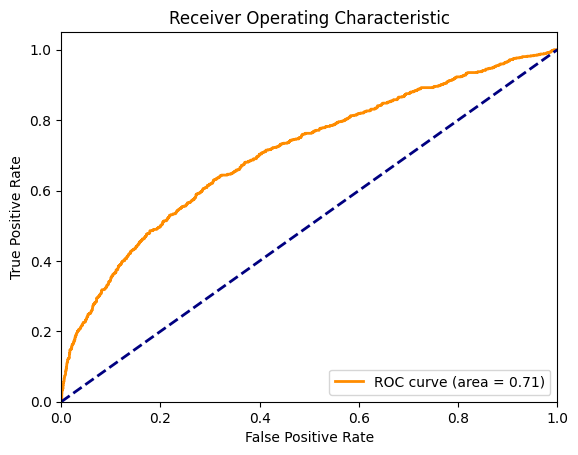

In [ ]:
import torch
from sklearn.metrics import roc_curve, auc

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    true_positives = 0
    predicted_positives = 0
    actual_positives = 0

    # Lists to store all predictions and labels
    all_labels = []
    all_predictions = []

    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        probabilities = torch.sigmoid(outputs)  # Assuming binary classification with sigmoid activation
        predictions = (probabilities >= 0.5).float()

        total += batch_y.size(0)
        correct += (predictions == batch_y).sum().item()

        actual_positives += (batch_y == 1).sum().item()
        predicted_positives += (predictions == 1).sum().item()
        true_positives += ((predictions == 1) & (batch_y == 1)).sum().item()

        # Append batch results to list
        all_labels.extend(batch_y.tolist())
        all_predictions.extend(probabilities.tolist())

    accuracy = 100 * correct / total
    precision = 100 * true_positives / predicted_positives if predicted_positives > 0 else 0
    recall = 100 * true_positives / actual_positives if actual_positives > 0 else 0

    # Calculate ROC AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)

    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}%')
    print(f'Recall: {recall:.2f}%')
    print(f'ROC AUC: {roc_auc:.2f}')

    # Optionally plot ROC curve
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


## New model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Neural_net(nn.Module):
    def __init__(self):
        super(Neural_net, self).__init__()
        self.fc1 = nn.Linear(44, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [ ]:
model = Neural_net()
model.train()
criterion = nn.BCEWithLogitsLoss()
weight_value = 2
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight_value]))
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

total_loss = 0
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs} Loss: {epoch_loss/len(train_loader)}')






Epoch 1/20 Loss: 0.8323386046707322
Epoch 2/20 Loss: 0.718056815970747
Epoch 3/20 Loss: 0.6954090274445751
Epoch 4/20 Loss: 0.6820303036064064
Epoch 5/20 Loss: 0.6732240660125728
Epoch 6/20 Loss: 0.6627617171082472
Epoch 7/20 Loss: 0.6532550522854909
Epoch 8/20 Loss: 0.6488022400461948
Epoch 9/20 Loss: 0.6397099783692335
Epoch 10/20 Loss: 0.6357901444938516
Epoch 11/20 Loss: 0.6311404548315187
Epoch 12/20 Loss: 0.6244488391311057
Epoch 13/20 Loss: 0.6269251534358208
Epoch 14/20 Loss: 0.6209184738175239
Epoch 15/20 Loss: 0.6146713912178198
Epoch 16/20 Loss: 0.6138058133770765
Epoch 17/20 Loss: 0.6097302334913935
Epoch 18/20 Loss: 0.6063309208021881
Epoch 19/20 Loss: 0.6015113563194794
Epoch 20/20 Loss: 0.6020232451394432


Accuracy: 68.16%
Precision: 15.87%
Recall: 40.02%
ROC AUC: 0.59


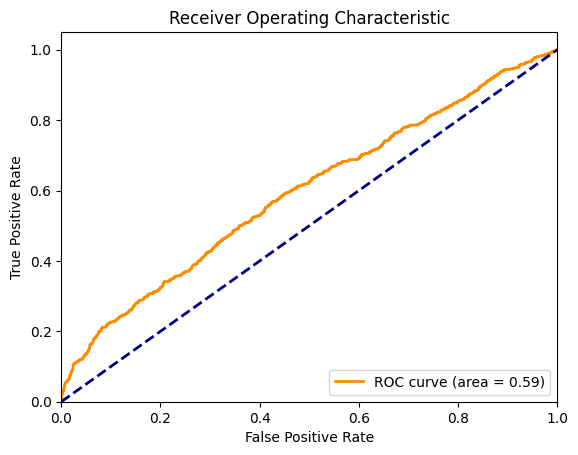

In [ ]:
import torch
from sklearn.metrics import roc_curve, auc

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    true_positives = 0
    predicted_positives = 0
    actual_positives = 0

    # Lists to store all predictions and labels
    all_labels = []
    all_predictions = []

    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        probabilities = torch.sigmoid(outputs)  # Assuming binary classification with sigmoid activation
        predictions = (probabilities >= 0.5).float()

        total += batch_y.size(0)
        correct += (predictions == batch_y).sum().item()

        actual_positives += (batch_y == 1).sum().item()
        predicted_positives += (predictions == 1).sum().item()
        true_positives += ((predictions == 1) & (batch_y == 1)).sum().item()

        # Append batch results to list
        all_labels.extend(batch_y.tolist())
        all_predictions.extend(probabilities.tolist())

    accuracy = 100 * correct / total
    precision = 100 * true_positives / predicted_positives if predicted_positives > 0 else 0
    recall = 100 * true_positives / actual_positives if actual_positives > 0 else 0

    # Calculate ROC AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)

    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}%')
    print(f'Recall: {recall:.2f}%')
    print(f'ROC AUC: {roc_auc:.2f}')

    # Optionally plot ROC curve
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


## New model with skip connections

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Neural_net(nn.Module):
    def __init__(self):
        super(Neural_net, self).__init__()
        self.fc1 = nn.Linear(44, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc2_skip = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc3_skip = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        identity1 = self.fc1(x)
        x = F.relu(self.bn1(identity1))
        x = self.dropout(x)

        identity2 = self.fc2_skip(identity1)
        x = F.relu(self.bn2(self.fc2(x) + identity2))
        x = self.dropout(x)

        identity3 = self.fc3_skip(x)
        x = F.relu(self.bn3(self.fc3(x) + identity3))
        x = self.dropout(x)

        x = self.fc4(x)
        return x


In [ ]:
model = Neural_net()
model.train()
criterion = nn.BCEWithLogitsLoss()
weight_value = 2
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight_value]))
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

total_loss = 0
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs} Loss: {epoch_loss/len(train_loader)}')






Epoch 1/20 Loss: 0.7784778989967287
Epoch 2/20 Loss: 0.6979503360591404
Epoch 3/20 Loss: 0.6724222785759466
Epoch 4/20 Loss: 0.655623461877435
Epoch 5/20 Loss: 0.6444793095319999
Epoch 6/20 Loss: 0.6285357205824531
Epoch 7/20 Loss: 0.6236985600674091
Epoch 8/20 Loss: 0.6124692817889347
Epoch 9/20 Loss: 0.6072981843213343
Epoch 10/20 Loss: 0.5973148718862336
Epoch 11/20 Loss: 0.593990572607579
Epoch 12/20 Loss: 0.5905066817381222
Epoch 13/20 Loss: 0.5848161285559748
Epoch 14/20 Loss: 0.5810633848368195
Epoch 15/20 Loss: 0.5762249115526368
Epoch 16/20 Loss: 0.5724577814572216
Epoch 17/20 Loss: 0.5671627405702759
Epoch 18/20 Loss: 0.5664277869648267
Epoch 19/20 Loss: 0.563436022925871
Epoch 20/20 Loss: 0.5595742123384859


Accuracy: 77.71%
Precision: 20.40%
Recall: 31.21%
ROC AUC: 0.60


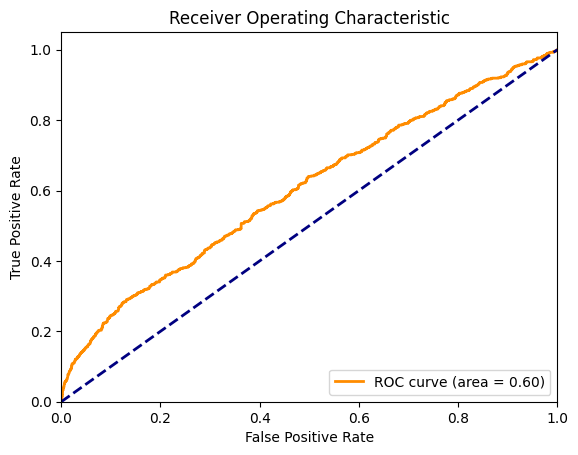

In [ ]:
import torch
from sklearn.metrics import roc_curve, auc

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    true_positives = 0
    predicted_positives = 0
    actual_positives = 0

    # Lists to store all predictions and labels
    all_labels = []
    all_predictions = []

    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        probabilities = torch.sigmoid(outputs)  # Assuming binary classification with sigmoid activation
        predictions = (probabilities >= 0.5).float()

        total += batch_y.size(0)
        correct += (predictions == batch_y).sum().item()

        actual_positives += (batch_y == 1).sum().item()
        predicted_positives += (predictions == 1).sum().item()
        true_positives += ((predictions == 1) & (batch_y == 1)).sum().item()

        # Append batch results to list
        all_labels.extend(batch_y.tolist())
        all_predictions.extend(probabilities.tolist())

    accuracy = 100 * correct / total
    precision = 100 * true_positives / predicted_positives if predicted_positives > 0 else 0
    recall = 100 * true_positives / actual_positives if actual_positives > 0 else 0

    # Calculate ROC AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)

    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}%')
    print(f'Recall: {recall:.2f}%')
    print(f'ROC AUC: {roc_auc:.2f}')

    # Optionally plot ROC curve
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
